In [1]:
import time
import glob
import os

#importing libraries for data manipulating
import numpy as np
import pandas as pd

#importing tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import torch

#import feature extraction libraries
import librosa
import librosa.display
from tqdm import tqdm
from python_speech_features import mfcc

#import libraries for plot and audio visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import seaborn as sns
from matplotlib.colors import ListedColormap

#importing sklearn libraries
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix, recall_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

This section is about loading the required libaries for the task. These libraries will be use to load the dataset(csv file and audios file), visualuisation of the data frame (wave plots), to extract the features using an appropriate technique within librosa library.

In [2]:
df=pd.read_csv("./archive/UrbanSound8K.csv")
classes=list(df["class"].unique())
paths=dict()
for i in range(len(classes)):
    temp_df=df[df["class"]==classes[i]].reset_index()
    fold=temp_df["fold"].iloc[0]   
    sample_name=temp_df["slice_file_name"].iloc[0]
    path="./archive/audio/fold{0}/{1}".format(fold, sample_name)
    paths[classes[i]]=path

This section is about defining the paths of the dataset and the metadata which the cvs file containing the information regarding the dataset. Firsly I loaded the csv file of the dataset with pandas. and also define the path of the audios file.

In [3]:
df.info()
df['class'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


children_playing    1000
engine_idling       1000
drilling            1000
street_music        1000
jackhammer          1000
air_conditioner     1000
dog_bark            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

This is about the information of the dataset reaging the dytpes. We can obverse that there are three types : float64(2), int64(4), object(2).The UrbanSound8k dataset is a collection of 8732 sounds files classified in 10 different classes.

In [4]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
df['fold'].value_counts()

4     990
5     936
3     925
2     888
1     873
7     838
10    837
6     823
9     816
8     806
Name: fold, dtype: int64

This section is about getting knowledge of dataset and the folds. 

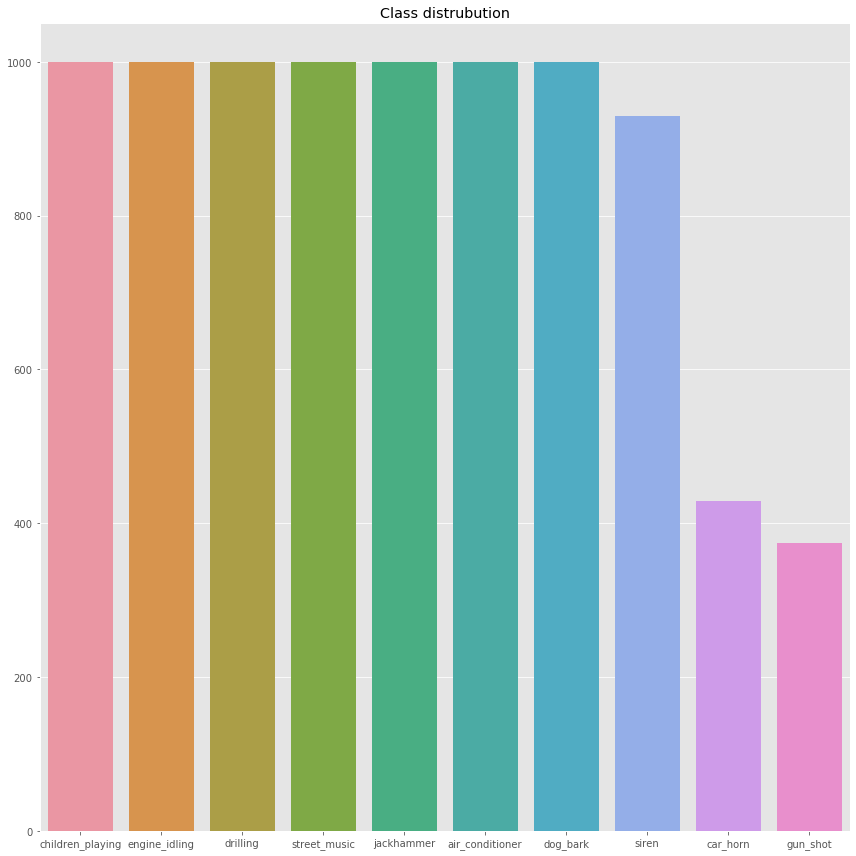

In [6]:
plt.figure(figsize=(12,12))
sns.barplot(x = df['class'].value_counts().index, y = df['class'].value_counts().values)
plt.title("Class distrubution")
plt.tight_layout()

This is about the distribution of the class of the dataset. Overall the graph shows that the dataset is unbalance, in fact the last three classes contain less information.

VISUALISATION OF THE AUDIOS FILE 

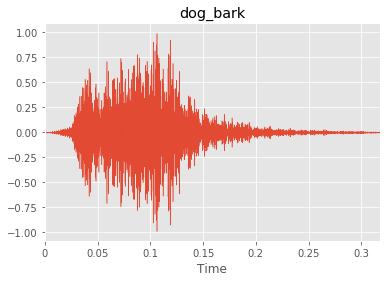

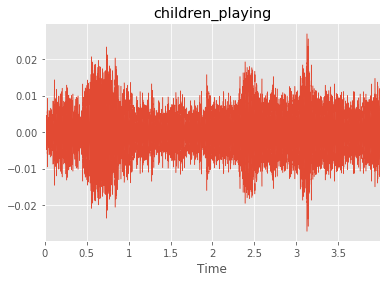

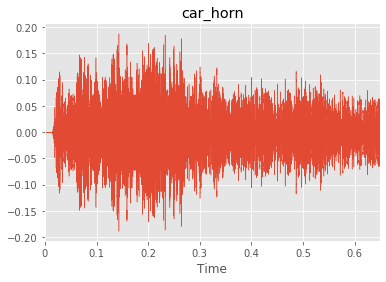

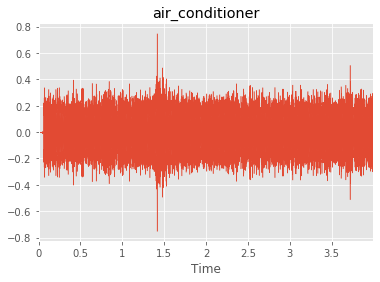

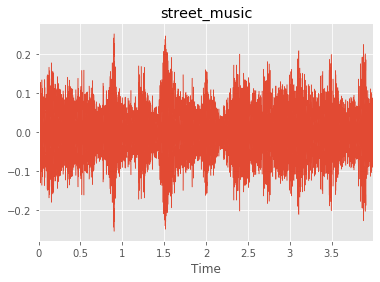

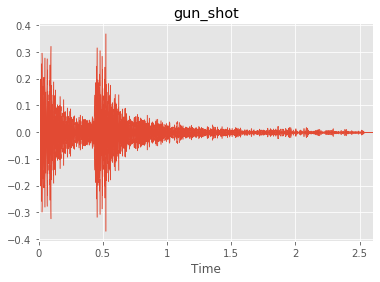

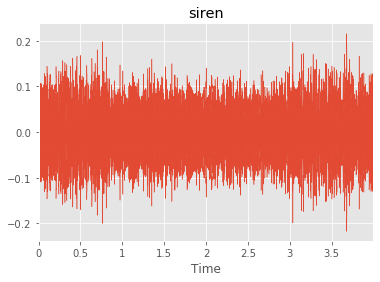

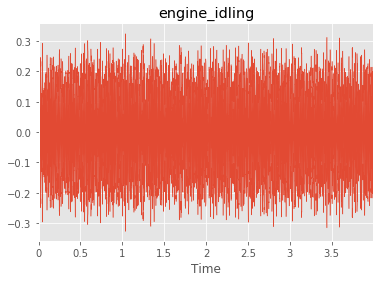

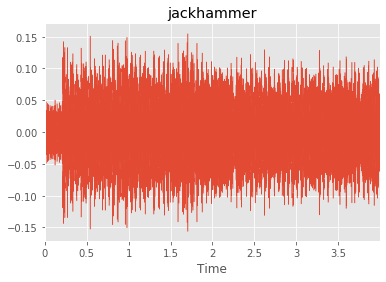

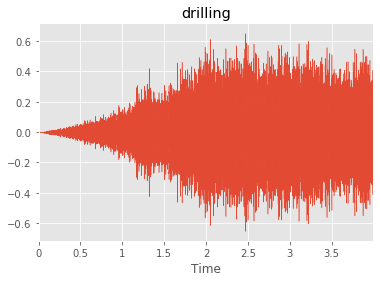

In [7]:
for i, label in enumerate(classes):
    sample=paths[label]
    plt.clf()
    plt.title(label)
    data, sample_rate=librosa.load(sample)
    librosa.display.waveplot(data, sr=sample_rate)
    plt.show()

We can spot differenced between the classes in terms of time and frequency.

After ploting out each class of the dataset, I will move into the extraction the features from each folds. The method for the extraction will be througth feature extraction functions of Librosa such as MFCC, it will be also scaled to normalize the features before passing into the independent variable

In [8]:
def extract_feature(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

This is code is about creating a helper that will able to extract the features from the audios fiile. This helper will extract in total 40 features (this is total amount) of mfccs. The features extracted will be scaled to normalizate the data. 

In [9]:
%%time
audiodata = []
for i in range(8732):
    file_name = './archive/audio/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
    final_class_labels=df["class"][i]
    data=extract_feature(file_name)
    audiodata.append([data,final_class_labels])

CPU times: user 35min 39s, sys: 19.8 s, total: 35min 59s
Wall time: 4min 29s


This function will loop between the 8732 audios files and extract the features along with the file_name and the class. I decided to store the features into a pandas dataframe so i will be able in case to manulipate it

In [10]:
features=pd.DataFrame(audiodata,columns=['feature','class'])
features.head()

,feature,class
0,"[-215.79301, 71.66612, -131.81377, -52.091335,...",dog_bark
1,"[-424.68677, 110.56227, -54.148235, 62.01074, ...",children_playing
2,"[-459.56467, 122.800354, -47.92471, 53.265697,...",children_playing
3,"[-414.55377, 102.896904, -36.66495, 54.18041, ...",children_playing
4,"[-447.397, 115.0954, -53.809113, 61.60859, 1.6...",children_playing


Inspecting the features dataframe.

In [11]:
features.head()

,feature,class
0,"[-215.79301, 71.66612, -131.81377, -52.091335,...",dog_bark
1,"[-424.68677, 110.56227, -54.148235, 62.01074, ...",children_playing
2,"[-459.56467, 122.800354, -47.92471, 53.265697,...",children_playing
3,"[-414.55377, 102.896904, -36.66495, 54.18041, ...",children_playing
4,"[-447.397, 115.0954, -53.809113, 61.60859, 1.6...",children_playing


In [12]:
features.tail()

,feature,class
8727,"[-399.2257, 136.81903, -51.964222, 37.02399, -...",car_horn
8728,"[-346.72733, 87.48847, -46.265022, 52.748833, ...",car_horn
8729,"[-304.61316, 112.6199, -47.161945, 37.00349, -...",car_horn
8730,"[-344.71423, 126.75813, -56.17717, 36.070927, ...",car_horn
8731,"[-315.93384, 95.67589, -38.04777, 47.50074, -7...",car_horn


These are the features extracted from the dataset(audio).

For feature selection, i decided to use all the features becuase i realise that all the features all important for the training. 

In [13]:
X = np.array(features['feature'].tolist())
y = np.array(features['class'].tolist())

setting the independent variable and dependent variable. I am also converting them into an numpy array, so i will be able to feed correctly my mdel 

I will check the shape of both variables.

In [14]:
scaler = MinMaxScaler()
X_= scaler.fit_transform(X)

In [15]:
X.shape

(8732, 40)

In [16]:
X = X.reshape(8732, 1, 40)

reshaping the X variable into a three dimensional, as the recurrent neural network required this shape. So the first dimension will be number, the second dimension will be the time and the last dimension will be the features. This process is only required for the input data(X).

In [17]:
y.shape

(8732,)

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = to_categorical(le.fit_transform(y))
print('Label Encoder')
print(y)
print(y)

Label Encoder
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


The previous y variable was only in 1 dimension, after enconding the label we have now 2 dimension, which contains the class of the dataset in a numerical format(array) instead of the previous format(category).

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.15, random_state=0, stratify=y)

spliting the dataset in train and test split, I set the test_size to 20%.

Inspecting and check the size of each variable, so we are sure of what data we are feedinfg the model.

In [20]:
X_train.shape

(7422, 1, 40)

In [21]:
X_test.shape

(1310, 1, 40)

In [22]:
y_train.shape

(7422, 10)

In [23]:
y_test.shape

(1310, 10)

MODEL SELECTION:

For the type of classification, i decided to use lstm and gru because of the effiency when it comes to deal audio dataset. In fact audio classification with LSTM has become popular in the recently years and has shown impressive accuracy rate in results. The same motivation is also valide for GRU, which also has shown very good results. A comparison will be done on both model to check which one performs better.

LSTM

In [24]:
def get_recurrent_model():
    input_shape=(1, 40)
    
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(TimeDistributed(Dense(128, activation='relu')))
    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

For LSTM, i decided to use 2 layers with 128 hidden units for both, a return_sequences to true so it can stack the two layers. A dropout(0.3) layer is also included to reduce overfitting. Two time distributed layers are included, the first one has the size 128 and the second one has a size of 256. In both layers, ReLU has been used as the activation function. A flatten layer is included for the 3D output. A dense layer set to 10 becuase the classes are 10. In final differet compile layer is added for metrics, optimizer and loss.

GRU:

In [25]:
def get_rnn_model():
    input_shape=(1, 40)
    
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=input_shape))
    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(TimeDistributed(Dense(128, activation='relu')))
    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

Same setting as the LTSM

In [26]:
model = get_recurrent_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            86528     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 128)            131584    
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 128)            16512     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 256)            33024     
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2

In [27]:
num_epochs = 100
num_batch_size = 32 
checkpointer = ModelCheckpoint(filepath = './lstm_inference.hdf5', verbose = 1, save_best_only= True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience=10)

For this model i choose 100 epochs because i want the model to train for a long time so i can check when the val_loss improvides and when not, secondly i added a earlystopping method to stop the training when the the model is not learning anymore. So the selection of number of the epochs is relative because when the model will stop when is not learning anymore(so setting a high number epochs is better becuase with small number of epochs the training can stop while it is still learning). For the Early Stopping i set the patience to 10, so the training will stop if for 10 epochs the model is not learning nothing. Num_batch to 32 and a check point which will save the model in a h5 file(for inference), this check point will only save the best one.

In [28]:
history = model.fit(X_train, y_train, batch_size = num_batch_size, epochs = num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer, es], verbose=1 )

Train on 7422 samples, validate on 1310 samples
Epoch 1/100
7136/7422 [===========================>..] - ETA: 0s - loss: 1.5857 - acc: 0.4340
Epoch 00001: val_loss improved from inf to 1.16257, saving model to ./lstm_inference.hdf5
7422/7422 [==============================] - 4s 483us/sample - loss: 1.5720 - acc: 0.4390 - val_loss: 1.1626 - val_acc: 0.5969
Epoch 2/100
7104/7422 [===========================>..] - ETA: 0s - loss: 1.0085 - acc: 0.6623
Epoch 00002: val_loss improved from 1.16257 to 0.87899, saving model to ./lstm_inference.hdf5
7422/7422 [==============================] - 1s 108us/sample - loss: 1.0090 - acc: 0.6613 - val_loss: 0.8790 - val_acc: 0.7244
Epoch 3/100
7008/7422 [===========================>..] - ETA: 0s - loss: 0.7778 - acc: 0.7447
Epoch 00003: val_loss improved from 0.87899 to 0.79988, saving model to ./lstm_inference.hdf5
7422/7422 [==============================] - 1s 102us/sample - loss: 0.7759 - acc: 0.7458 - val_loss: 0.7999 - val_acc: 0.7427
Epoch 4/100

We can see that the model stop training at the 35 epochs because the model stop learning from the 25th epochs

Plotting some graph to check the performance of the model, also to check any overfitting or underfitting.

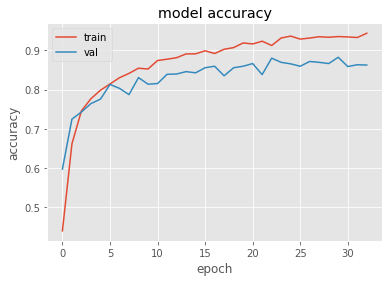

In [29]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

This plot is displaying the accuracy and the validation accuracy. we can that there is not overfitting.

LOSS of the model

<function matplotlib.pyplot.show(*args, **kw)>

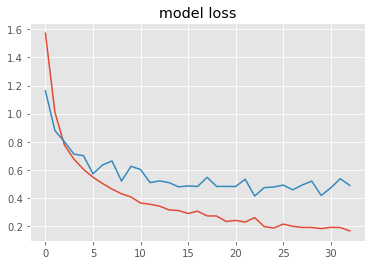

In [30]:
plt.title('model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show

This plot is displaying the model loss and the validation loss. we can that there is not overfitting.

In [31]:
score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.95742387
Testing Accuracy:  0.86259544


This the percentage of the training accuracy and the testing accury.

EVALUATION OF THE MODELS

In [32]:
prediction = model.predict(X_test)

In [33]:
pred = recall_score(np.argmax(y_test, axis = 1), np.argmax(prediction, axis=1), average = 'macro')

In [34]:
print(confusion_matrix(np.argmax(y_test, axis = 1),np.argmax(prediction, axis=1)))

[[139   0   2   1   0   3   0   2   1   2]
 [  0  54   0   0   2   2   0   1   1   4]
 [  2   0 128   5   1   0   6   1   0   7]
 [  0   2  10 111   4   2   8   0   8   5]
 [  1   0   3   5 130   2   0   8   0   1]
 [  0   0   4   0   0 146   0   0   0   0]
 [  0   0   2   5   0   0  43   0   2   4]
 [  1   0   1   0   4   0   0 143   0   1]
 [  0   0   4   3   0   0   0   0 133   0]
 [  7   3  20   5   6   1   2   2   1 103]]


In [35]:
cm = confusion_matrix(np.argmax(y_test, axis = 1),np.argmax(prediction, axis=1))

In [36]:
print(classification_report(np.argmax(y_test, axis = 1),np.argmax(prediction, axis=1), zero_division=1))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       150
           1       0.92      0.84      0.88        64
           2       0.74      0.85      0.79       150
           3       0.82      0.74      0.78       150
           4       0.88      0.87      0.88       150
           5       0.94      0.97      0.95       150
           6       0.73      0.77      0.75        56
           7       0.91      0.95      0.93       150
           8       0.91      0.95      0.93       140
           9       0.81      0.69      0.74       150

    accuracy                           0.86      1310
   macro avg       0.86      0.86      0.86      1310
weighted avg       0.86      0.86      0.86      1310



In [37]:
auc_ltsm = roc_auc_score(y_test, prediction)
print('AUC: %.3f' % auc_ltsm)

AUC: 0.986


In [38]:
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)

TN = cm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

SENSITIVITY

In [39]:
TPR = TP/(TP+FN)

In [40]:
TPR

array([0.92666667, 0.84375   , 0.85333333, 0.74      , 0.86666667,
       0.97333333, 0.76785714, 0.95333333, 0.95      , 0.68666667])

SPECIFICITY

In [41]:
TNR = TN/(TN+FP)

In [42]:
TNR

array([0.99051724, 0.99598716, 0.96034483, 0.97931034, 0.98534483,
       0.99137931, 0.98724083, 0.98793103, 0.98888889, 0.97931034])

RESULST ON LTSM:

This network is actually performing very well as we can noticed in the classidcation report, confusion matrix, the sensivity, the specificty and AUC SCORE. In fact all the values return shows the model the near 1.0 which means the model is very good. But we can also noticed in some classes the model performs worst(but still good enough) probarbily because the dataset is unbalanced. 

----------------

GRU

In [43]:
model1 = get_rnn_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 128)            65280     
_________________________________________________________________
gru_1 (GRU)                  (None, 1, 128)            99072     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 128)            16512     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 256)            33024     
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [44]:
num_epochs = 100
num_batch_size = 32 
checkpointer = ModelCheckpoint(filepath = './GRU_inference.hdf5', verbose = 1, save_best_only= True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience=10)

In [45]:
history1= model1.fit(X_train, y_train, batch_size = num_batch_size, epochs = num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer, es], verbose=1 )

Train on 7422 samples, validate on 1310 samples
Epoch 1/100
7200/7422 [============================>.] - ETA: 0s - loss: 1.5469 - acc: 0.4571
Epoch 00001: val_loss improved from inf to 1.16042, saving model to ./GRU_inference.hdf5
7422/7422 [==============================] - 3s 384us/sample - loss: 1.5361 - acc: 0.4613 - val_loss: 1.1604 - val_acc: 0.6115
Epoch 2/100
6752/7422 [==========================>...] - ETA: 0s - loss: 1.0277 - acc: 0.6600
Epoch 00002: val_loss improved from 1.16042 to 0.93926, saving model to ./GRU_inference.hdf5
7422/7422 [==============================] - 1s 95us/sample - loss: 1.0193 - acc: 0.6637 - val_loss: 0.9393 - val_acc: 0.6840
Epoch 3/100
7136/7422 [===========================>..] - ETA: 0s - loss: 0.8327 - acc: 0.7267
Epoch 00003: val_loss improved from 0.93926 to 0.93231, saving model to ./GRU_inference.hdf5
7422/7422 [==============================] - 1s 100us/sample - loss: 0.8299 - acc: 0.7270 - val_loss: 0.9323 - val_acc: 0.6977
Epoch 4/100
720

We can see that the model stop training at the 35 epochs because the model stop learning from the 22th epochs

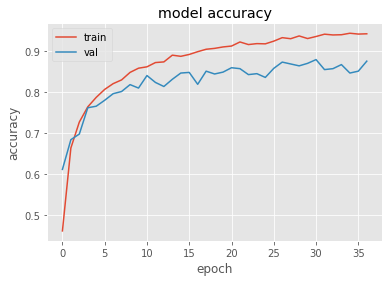

In [46]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

This plot is displaying the accuracy and the validation accuracy. we can that there is not overfitting.

<function matplotlib.pyplot.show(*args, **kw)>

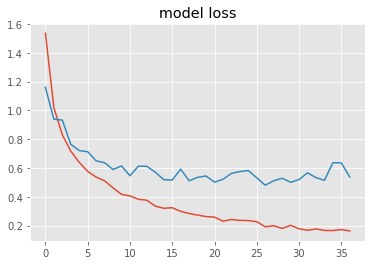

In [47]:
plt.title('model loss')
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.show

This plot is displaying the model loss and the validation loss. we can that there is not overfitting.

In [48]:
prediction = model1.predict(X_test)

In [49]:
score = model1.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model1.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9710321
Testing Accuracy:  0.8755725


This the percentage of the training accuracy and the testing accury.

MODEL EVALUATION 

In [50]:
pred = recall_score(np.argmax(y_test, axis = 1), np.argmax(prediction, axis=1), average = 'macro')

In [51]:
print(confusion_matrix(np.argmax(y_test, axis = 1),np.argmax(prediction, axis=1)))

[[141   1   1   0   0   1   1   3   1   1]
 [  1  60   0   1   0   0   0   2   0   0]
 [  7   3 119   3   2   2   0   0   1  13]
 [  4   4   4 122   3   1   5   1   2   4]
 [  2   3   4   2 123   0   3   5   1   7]
 [  1   3   0   0   0 140   1   0   3   2]
 [  2   0   7   3   0   0  38   2   2   2]
 [  1   1   0   0   1   0   0 146   0   1]
 [  1   0   2   4   0   1   0   0 131   1]
 [  4   5   4   0   1   2   3   3   1 127]]


In [52]:
conf_mat = confusion_matrix(np.argmax(y_test, axis = 1),np.argmax(prediction, axis=1))

In [53]:
print(classification_report(np.argmax(y_test, axis = 1),np.argmax(prediction, axis=1), zero_division=1))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       150
           1       0.75      0.94      0.83        64
           2       0.84      0.79      0.82       150
           3       0.90      0.81      0.86       150
           4       0.95      0.82      0.88       150
           5       0.95      0.93      0.94       150
           6       0.75      0.68      0.71        56
           7       0.90      0.97      0.94       150
           8       0.92      0.94      0.93       140
           9       0.80      0.85      0.82       150

    accuracy                           0.88      1310
   macro avg       0.86      0.87      0.86      1310
weighted avg       0.88      0.88      0.88      1310



In [54]:
FP1 = conf_mat.sum(axis=0) - np.diag(conf_mat)
FN1 = conf_mat.sum(axis=1) - np.diag(conf_mat)
TP1 = np.diag(conf_mat)

TN1 = conf_mat.sum() - (FP1 + FN1 + TP1)
FP1 = conf_mat.astype(float)
FN1 = conf_mat.astype(float)
TP1 = conf_mat.astype(float)
TN1 = conf_mat.astype(float)

SENSITIVITY

SPECIFICITY

In [55]:
auc_gru = roc_auc_score(y_test, prediction)
print('AUC: %.3f' % auc_gru)

AUC: 0.984


---------

COMPARE AUC VALUES:

In [56]:
print("AUC SCORE BETWEEN LSTM AND GRU(RECURRENT NEURAL NETWORK):")
print('LSTM CUML AUC SCORE: %.3f' % auc_ltsm)
print('GRUC SKLEARN AUC SCORE: %.3f' % auc_gru)

AUC SCORE BETWEEN LSTM AND GRU(RECURRENT NEURAL NETWORK):
LSTM CUML AUC SCORE: 0.986
GRUC SKLEARN AUC SCORE: 0.984


-------

RESULTS:

After training both recurrent neural network, lstm and gru, I noticed that the results are good and very close to each other, whhich means both rnn are powerful networks for audio classification. Howerver it looks like lstm is able to archive better in comparition with GRU, in fact checking the training accuracy, testing accuracy and AUC scores, it shows that the values in lstm are a bit better. Secondly focusing on the confusion metric, we can see that the recall also know as sensitivity that the model is good in many classes except just two or three classes, the reason can be because the dataset is unbalanced. But we can also deduce as all the recall values are greater than 0.6 THE model is definitely performing well. Overall we can also the little between the networks in the comparison done the AUC VALUES

--------

INFERENCE

In [74]:
def predict_model(folder_path,file_name):

    loaded_model = load_model("./lstm_inference.hdf5")
    file_path = folder_path + '/' + file_name
    feat = extract_feature(file_path)
    feat = feat.reshape(1,40)
    feat = scaler.transform(feature)
    feat = feature.reshape(1,1,40)


    pred_v = loaded_model.predict(feature)[0]
    prediction = le.inverse_transform([np.argmax(pred_v)])
    print('Predicted Class is : ',prediction[0])
    print ('Real Class is : ',df[df['slice_file_name']==file_name]['class'].values[0])

In [67]:
predict_model('./archive/audio/fold2','110688-3-0-11.wav')

Predicted Class is :  dog_bark
Real Class is :  dog_bark


In [68]:
predict_model('./archive/audio/fold2','100652-3-0-2.wav')

Predicted Class is :  dog_bark
Real Class is :  dog_bark


ERROR

In [77]:
predict_model('./archive/audio/fold2','110688-3-0-11.wav')

Predicted Class is :  gun_shot
Real Class is :  dog_bark


For the inference i tried to test the dataset, and we can see that it able to predict well very, but during this inference the i noticed there few error which means the model can be improved. In fact according the author using cross validation can improve the training and inferences.

--------